In [1]:
import pandas as pd
import numpy as np
import os
from PIL import *
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
keyfacial_df = pd.read_csv('../P96-Section-2-Emotion-AI/Emotion AI Dataset/data.csv')

In [5]:
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96,96))

In [6]:
keyfacial_df['Image'][0].shape

(96, 96)

In [7]:
keyfacial_df.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        2140.000000        2140.000000         2140.000000   
mean           66.221549          36.842274           29.640269   
std             2.087683           2.294027            2.051575   
min            47.835757          23.832996           18.922611   
25%            65.046300          35.468842           28.472224   
50%            66.129065          36.913319           29.655440   
75%            67.332093          38.286438           30.858673   
max            78.013082          46.132421           42.495172   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         2140.000000              2140.000000              2140.000000   
mean            37.063815                59.272128                37.856014   
std              2.234334                 2.005631                 2.034500   
min             24.773072                41.779381                27.190098   
25%             35.818377                58.113054                36.607950   
50%             37.048085                59.327154                37.845220   
75%             38.333884                60.521492                39.195431   
max             45.980981                69.023030                47.190316   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2140.000000              2140.000000   
mean                 73.412473                37.640110   
std                   2.701639                 2.684162   
min                  52.947144                26.250023   
25%                  71.741978                36.102409   
50%                  73.240045                37.624207   
75%                  74.978684                39.308331   
max                  87.032252                49.653825   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2140.000000               2140.000000  ...  2140.000000   
mean                  36.603107                 37.920852  ...    47.952141   
std                    1.822784                  2.009505  ...     3.276053   
min                   24.112624                 26.250023  ...    24.472590   
25%                   35.495730                 36.766783  ...    46.495330   
50%                   36.620735                 37.920336  ...    47.900511   
75%                   37.665280                 39.143921  ...    49.260657   
max                   47.293746                 44.887301  ...    65.279654   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  2140.000000          2140.000000          2140.000000   
mean     57.253926            63.419076            75.887660   
std       4.528635             3.650131             4.438565   
min      41.558400            43.869480            57.023258   
25%      54.466000            61.341291            72.874263   
50%      57.638582            63.199057            75.682465   
75%      60.303524            65.302398            78.774969   
max      75.992731            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2140.000000           2140.000000             2140.000000   
mean              32.967365             76.134065               48.081325   
std                3.595103              4.259514                2.723274   
min                9.778137             56.690208               32.260312   
25%               30.879288             73.280038               46.580004   
50%               33.034022             75.941985               47.939031   
75%               35.063575             78.884031               49.290000   
max               50.973348             93.443176               61.804506   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2140.000000                2140.000000   
mean                72.681125                  48.149654

In [8]:
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

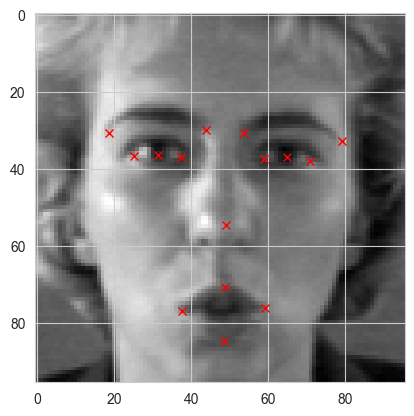

In [9]:
i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap='gray')

for j in range (1, 31, 2):
    plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

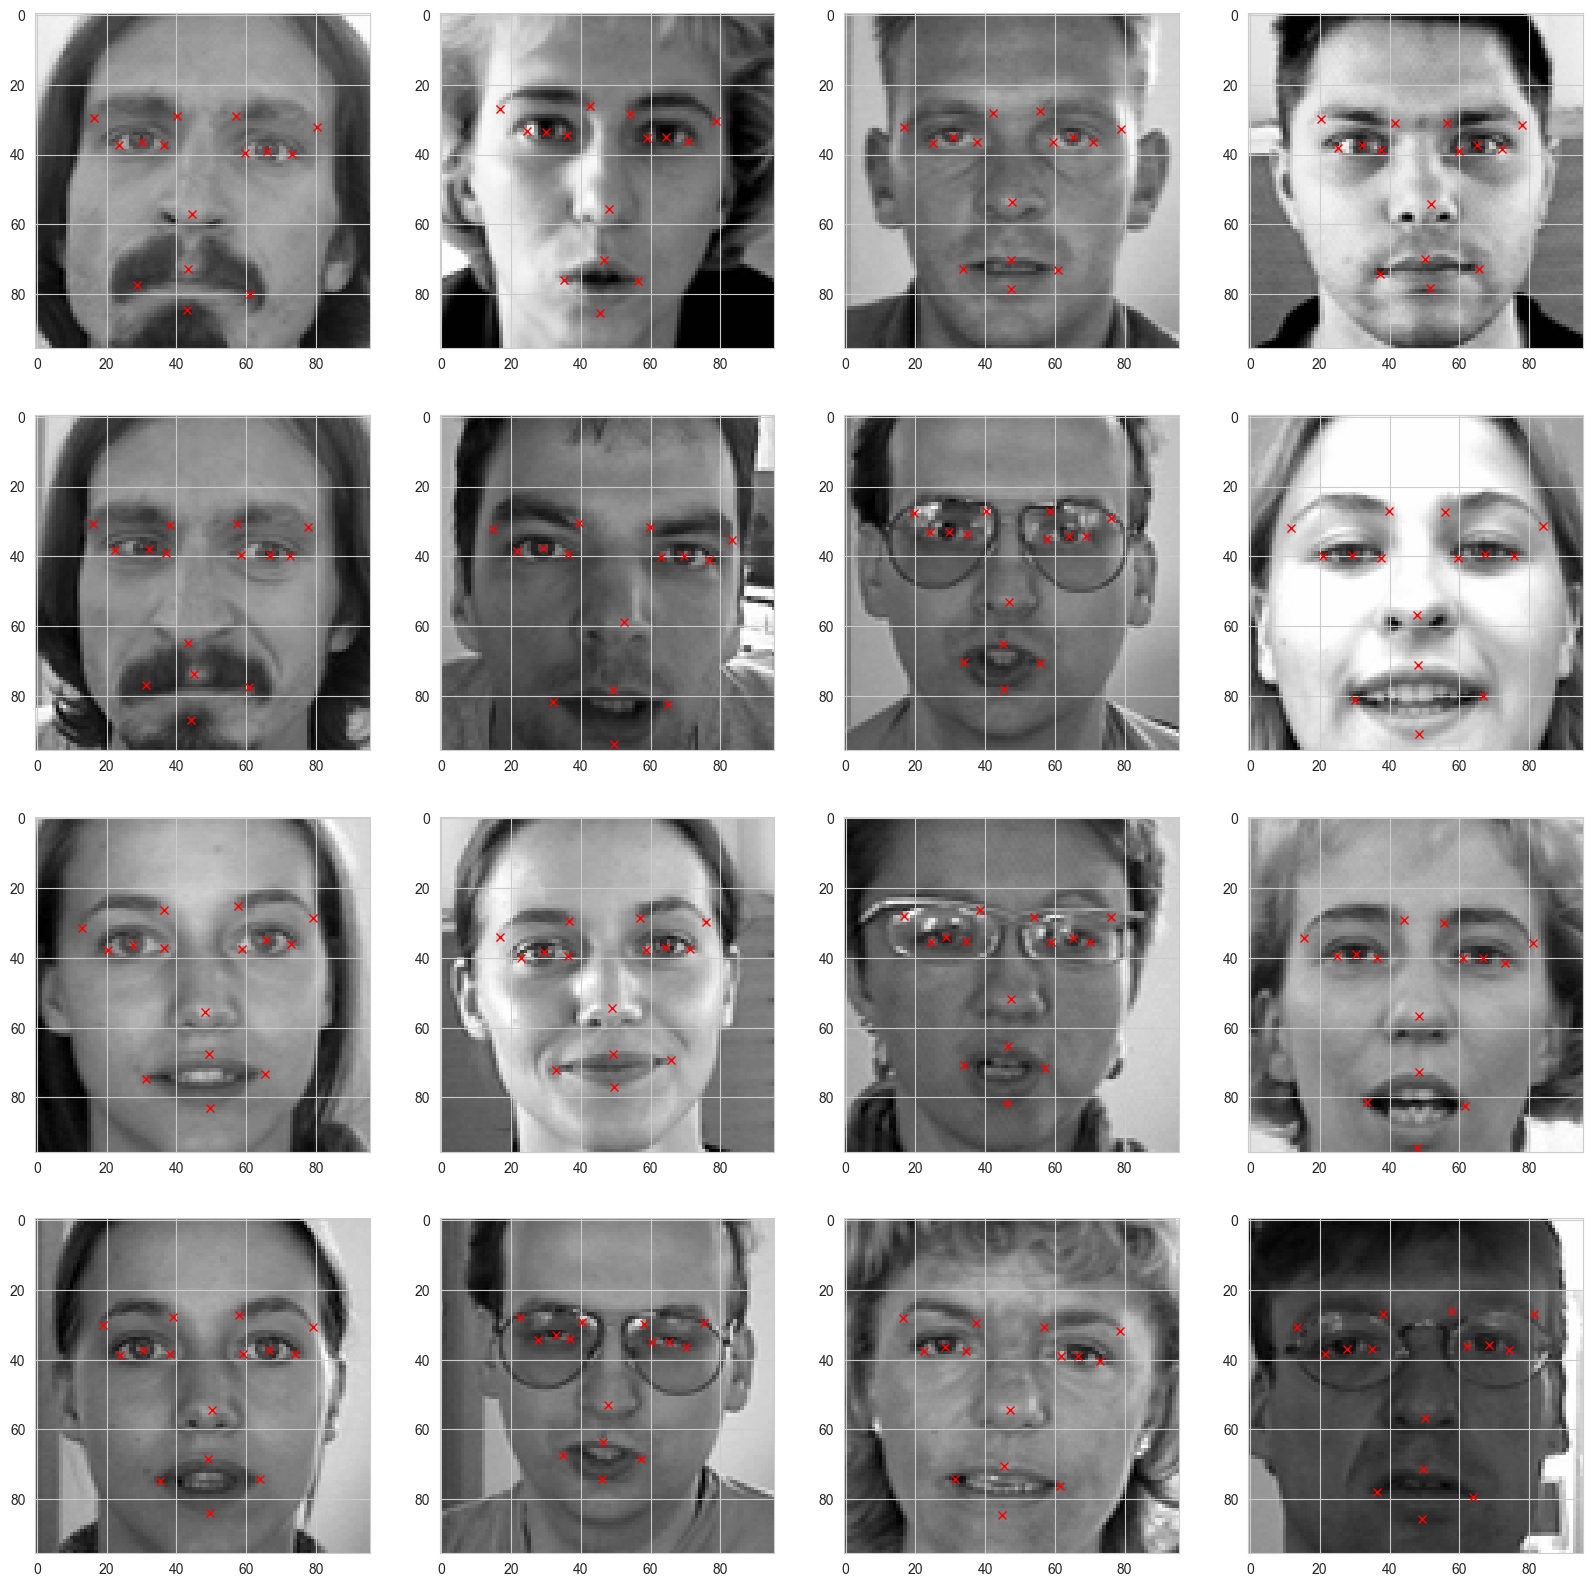

In [10]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    ax.imshow(keyfacial_df['Image'][i], cmap='gray')
    for j in range(1,31,2):
        ax.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

In [11]:
random_indexes = np.random.randint(0, len(keyfacial_df), size=64)
print(enumerate(random_indexes))
print(random_indexes)

[ 232 1478  850  960  560  706  463 1397 1512 1240  969  618 1969  889
  152  412 1073  499  550  911  566 1437 2087  665 1758  767  130    1
 1806 1485  796   15  529 1054 1819 1187  306 1015  617 2083  349 1747
 1077 1052 1269 1274 1974 1386  611 1603 1249  288  628 2131 1295 1123
 1399 1866   60 1335 1006 1954 1300  286]


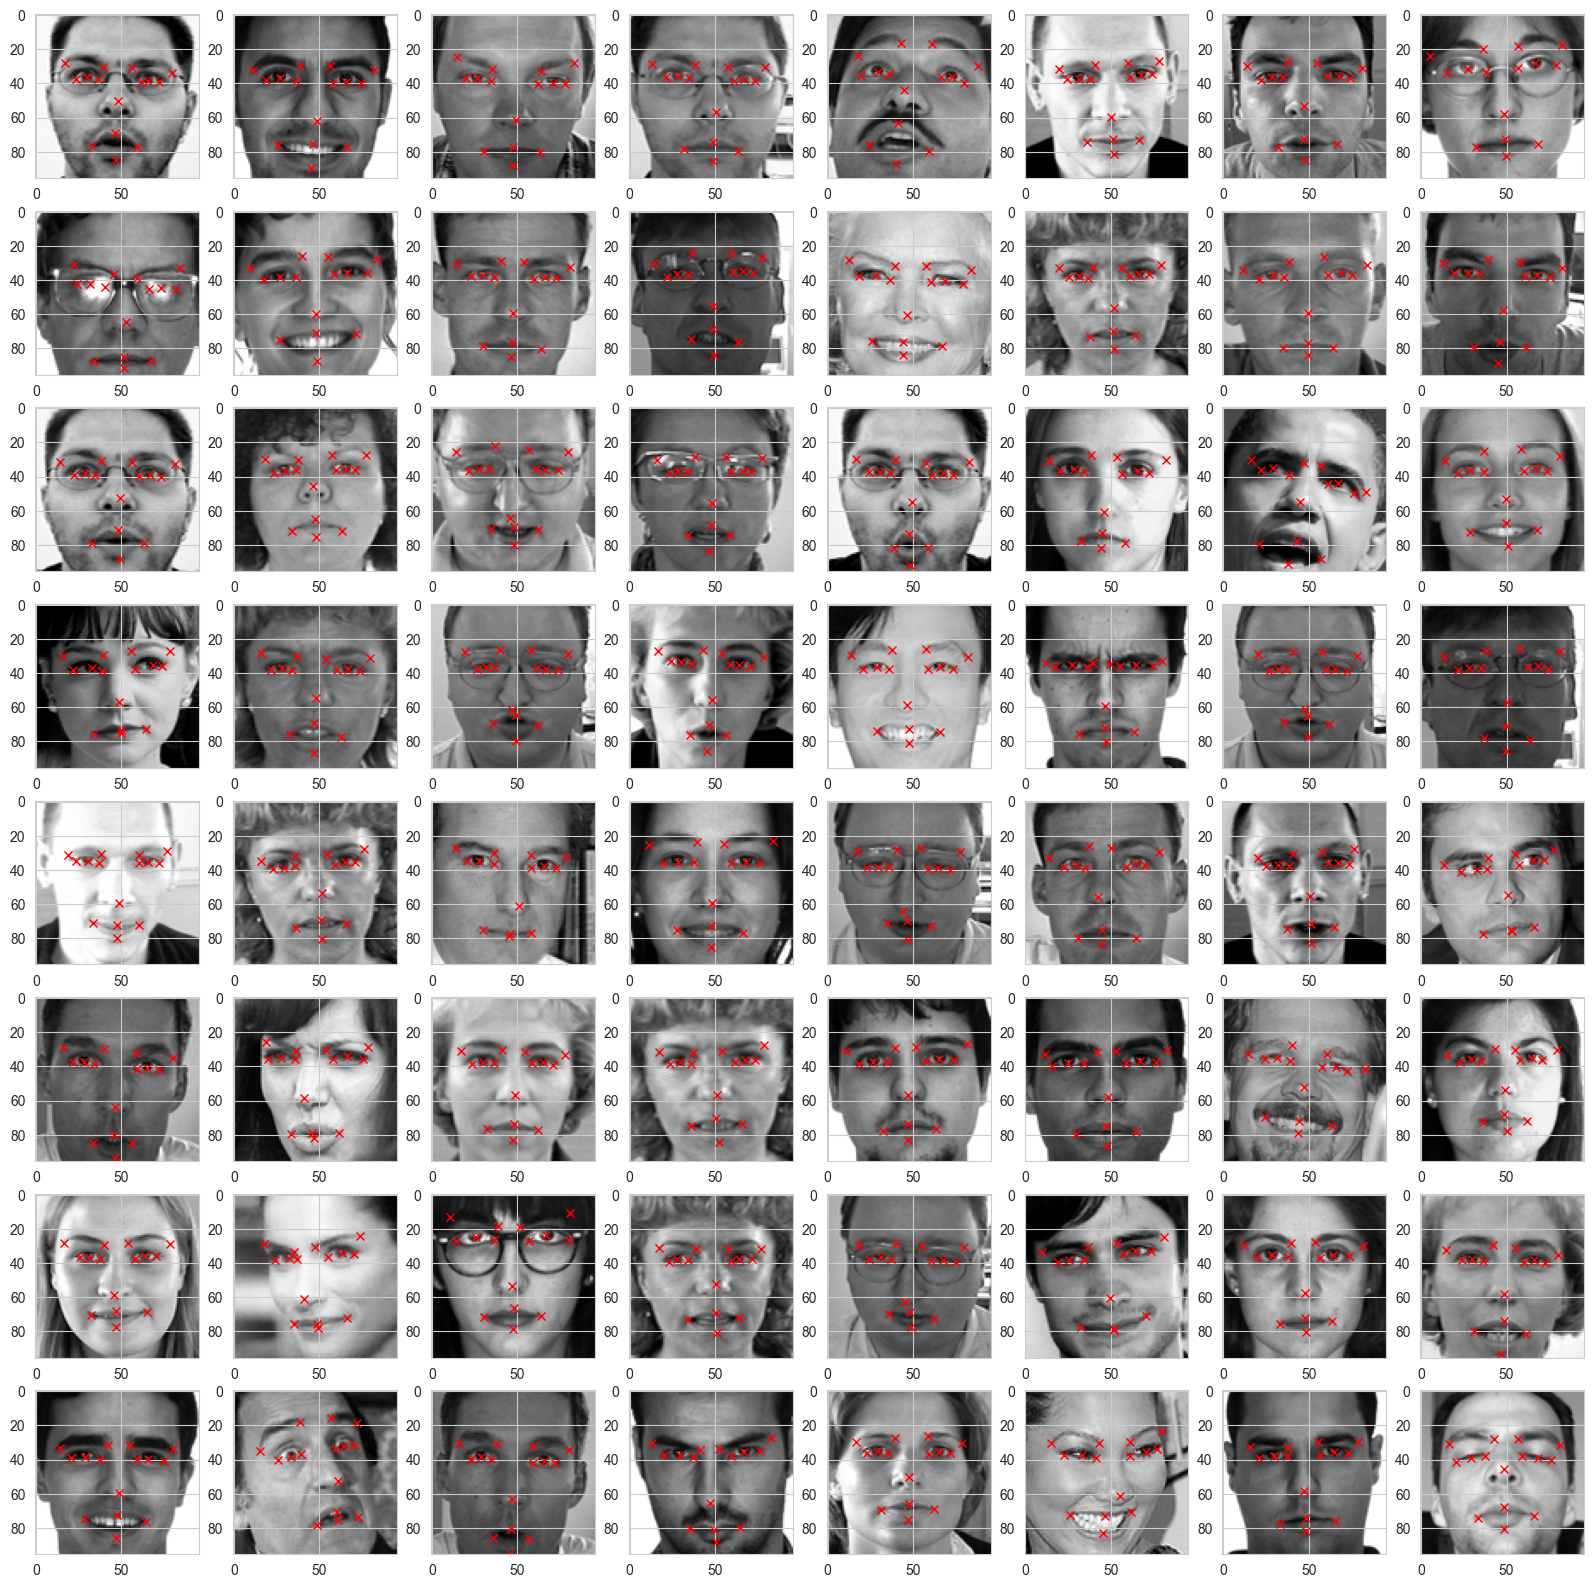

In [12]:
fig = plt.figure(figsize=(20,20))
for i, idx in enumerate(random_indexes):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(keyfacial_df['Image'][idx], cmap='gray')
    for j in range(1,31,2):
        ax.plot(keyfacial_df.loc[idx][j-1], keyfacial_df.loc[idx][j], 'rx')

In [13]:
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [14]:
columns = keyfacial_df_copy.columns[:-1]
# how come does this return every but a last column? 
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [15]:
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis=1))

for i in range (0, 30, 2):
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))

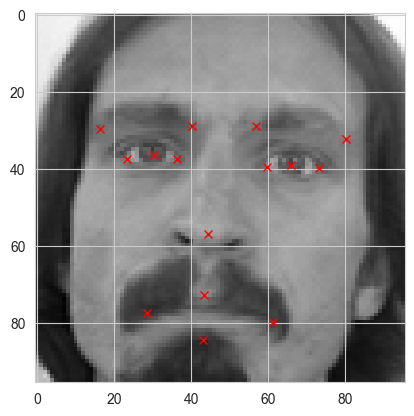

In [16]:
plt.imshow(keyfacial_df['Image'][0], cmap='gray')
for j in range (1, 31, 2):
    plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

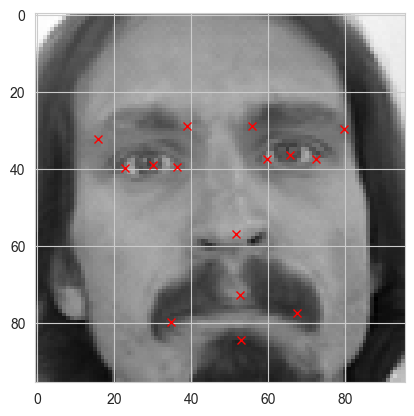

In [17]:
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range (1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [18]:
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [19]:
augmented_df.shape

(4280, 31)

In [20]:
keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.clip(np.random.uniform(1.5, 2) * x, 0.0, 255.0))

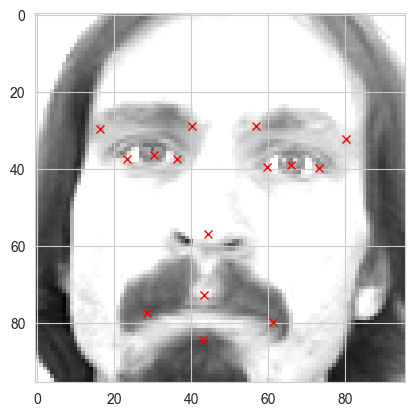

In [21]:
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range (1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [22]:
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))

In [23]:
keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis=0))

In [24]:
columns = keyfacial_df_copy.columns[:-1]

In [25]:
for i in range (1, 30, 2):
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))

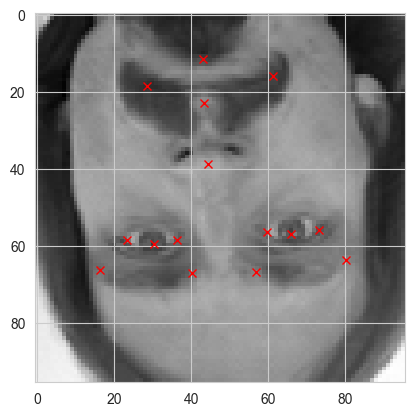

In [26]:
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range (1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

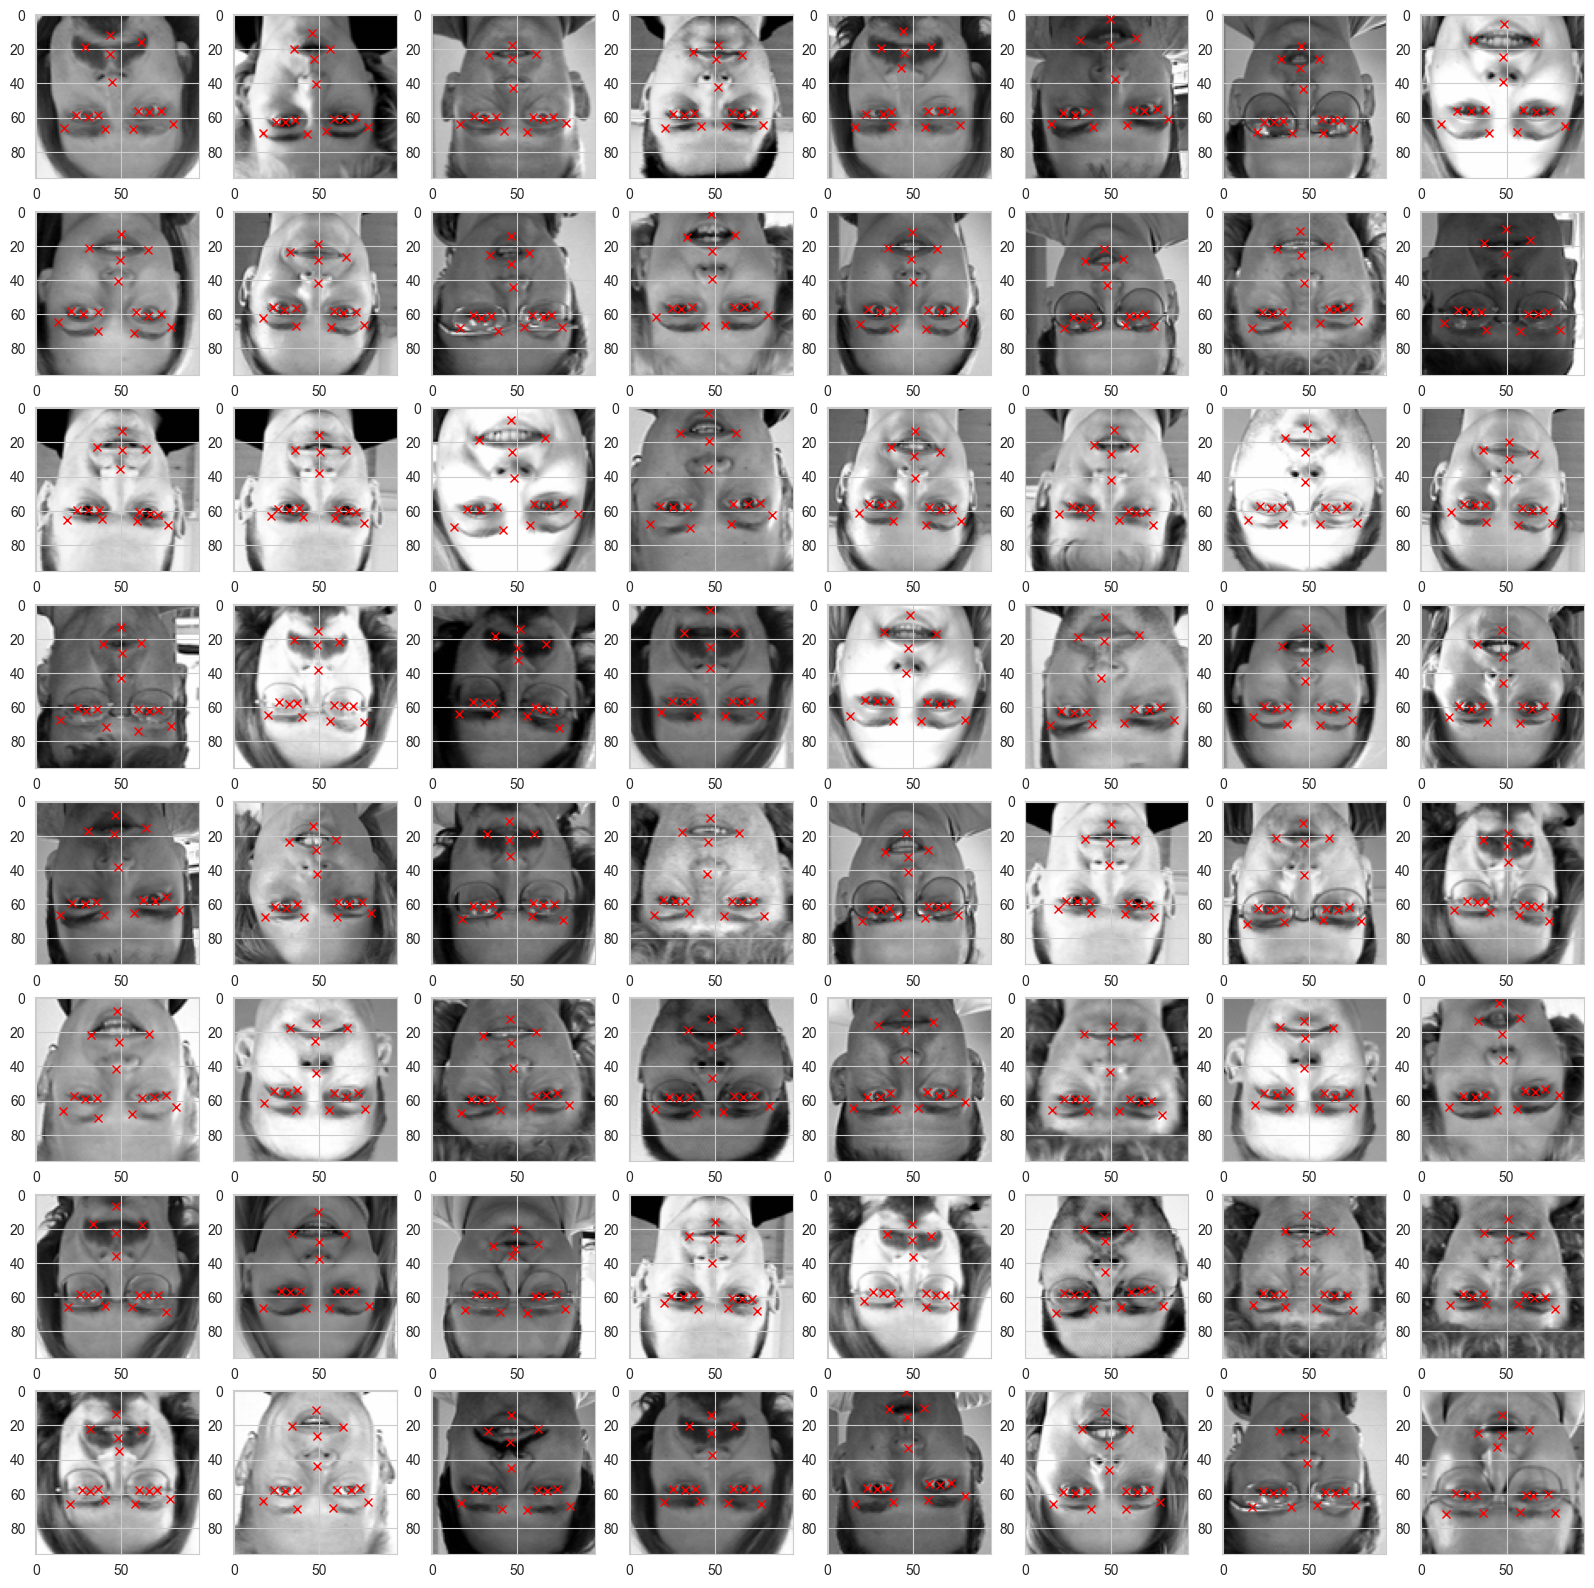

In [27]:
fig = plt.figure(figsize=(20,20))

for i in range(64):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(keyfacial_df_copy['Image'][i], cmap='gray')
    for j in range(1,30,2):
        ax.plot(keyfacial_df_copy.loc[i][j-1], keyfacial_df_copy.loc[i][j], 'rx')

In [28]:
img = augmented_df[:,30]

In [29]:
img.shape

(6420,)

In [30]:
img = img/ 255.

In [31]:
X = np.empty((len(img), 96, 96, 1))
for i in range(len(img)):
    X[i,] = np.expand_dims(img[i], axis=2)
    
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [32]:
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [34]:
# activation functions: tanh, sigmoid, relu, leaky relu, elu - what are the differences? 

In [35]:
# NN architectures: ANN, CNN, 
# RNN - temporal information captured; applications: speech recognition, language modeling, translation, image captioning, time series prediction

In [36]:
# ResNet vs Alexnet

In [37]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [38]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 18,016,286
Trainable params: 18,007,710
Non-trainable params: 8,576
__________________________________________________________________________________________________


In [40]:
from tensorflow.keras.optimizers import SGD
# from keras.optimizers.optimizer_v2.adam import Adam
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras import *
# adam = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = 'adam' , metrics = ['accuracy'])
# Check this out for more information on Adam optimizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [41]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [42]:
# reduce learning rate when the model performance has plateaued
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_lr = 0.0001)


In [43]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 32, epochs = 2, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/2
172/172 [==============================] - 59s 325ms/step - loss: 890.7169 - accuracy: 0.6196 - val_loss: 497.5271 - val_accuracy: 0.7059

Epoch 1: val_loss improved from inf to 497.52713, saving model to FacialKeyPoints_weights.hdf5


KeyError: 'input_1_ib-0'